### Basic imports and setting up OpenAI and Tavily integration


In [245]:
import os
from langchain_openai import ChatOpenAI
from dotenv import load_dotenv


load_dotenv()
llm = ChatOpenAI(
    model_name="gpt-4o-mini",
    openai_api_key=os.environ['OPENAI_API_KEY_TEG'],
    temperature=0,
)


### Moj własny tool


In [246]:
from langchain.tools import Tool

def calculate_loss(time_lost_seconds: int, avg_salary_per_hour: float = 50) -> float:
    """
    Oblicza stratę finansową firmy na podstawie straconego czasu (w sekundach)
    i stawki godzinowej (domyślnie 50 PLN/h).
    """
    hours = time_lost_seconds / 3600
    return round(hours * avg_salary_per_hour, 2)

agent2_tools = [
    Tool.from_function(
        func=calculate_loss,
        name="CalculateTimeLoss",
        description="Oblicza stratę finansową firmy na podstawie czasu straconego w sekundach i stawki godzinowej (domyślnie 50 PLN/h). Wymaga: time_lost_seconds jako liczby całkowitej. Zwraca stratę w zł."
    )
]




### Definicja Tools

In [260]:
from langchain_community.utilities.sql_database import SQLDatabase
from langchain.agents.agent_toolkits import SQLDatabaseToolkit
from langchain.tools.tavily_search import TavilySearchResults
import os   
from langchain.tools import Tool
from dotenv import load_dotenv
load_dotenv()

db_path = r"C:\PJATK\SEMESTR2\teg projekt\projekt\Logi-projektTEG\parser\logs.db"

sql_db = SQLDatabase.from_uri(f"sqlite:///{db_path}")
sql_toolkit = SQLDatabaseToolkit(db=sql_db, llm=llm)  
agent1_tools = [tool for tool in sql_toolkit.get_tools() if tool.name != "sql_db_list_tables"]
tavily = TavilySearchResults(max_results=5)


def run_sql_query(query: str) -> str:
    print(f"[DEBUG] Running SQL query:\n{query}")
    result = sql_db.run(query)
    print(f"[DEBUG] SQL query result:\n{result}")
    return str(result)

#-----------------------------------#-----------------------------------#-----------------------------------#-----------------------------------
def clean_sql_response(response: str) -> str:
    response = response.strip()
    if response.lower().startswith("sqlquery:"):
        response = response[len("sqlquery:"):].strip()
    response = response.replace("```sql", "").replace("```", "")
    response = "\n".join(line.strip() for line in response.splitlines() if line.strip())
    return response

def cleaned_sql_tool(query: str) -> str:
    cleaned_query = clean_sql_response(input_query)
    result = run_sql_query(cleaned_query) 
    return f"Wynik zapytania SQL: {result}"

sql_query_tool = Tool.from_function(
    func=cleaned_sql_tool,
    name="run_clean_sql_query",
    description="Wykonuje oczyszczone zapytanie SQL (z usuniętym SQLQuery:, markdown itd.). Podaj pełne zapytanie wygenerowane przez LLM.",
)
#-----------------------------------#-----------------------------------#-----------------------------------#-----------------------------------
tools = agent1_tools + [tavily, sql_query_tool] + agent2_tools


### Defining the prompts for each agent role

In [268]:
search_template = """
                     Jesteś ekspertem SQL. Twoim jedynym zadaniem jest konwersja zapytań użytkownika do zapytań SQL.
                    Nie używaj narzędzi takich jak `sql_db_list_tables`. Zakładamy, że znasz strukturę tabel.

                    Zawsze generuj **kompletne zapytanie SQL**, jako:
                    SQLQuery: ```sql
                    SELECT ...              
                  Not permit risky SQL generation (e.g., DROP, DELETE) 
                  Duration is the time spent on the app by the user in seconds.
                  """
value_template = """
                    Jesteś agentem do prostych obliczeń matematycznych.

Dostajesz tekst, w którym znajduje się liczba sekund.
Twoim zadaniem jest wyciągnąć tę liczbę sekund, przeliczyć na godziny (sekundy / 3600),
a następnie przemnożyć przez stawkę godzinową podaną w PLN równa 50 PLN.

Na końcu zwróć wynik w naturalnym języku, np.:
"Czas trwania akcji to X godzin, co przy stawce Y PLN/h daje koszt Z PLN."

Jeśli nie znajdziesz liczby sekund w tekście, powiedz, że brak danych do obliczeń.
                    """
exchange_template = """Convert the total company losses into multiple currencies and assets: USD, EUR, GBP, BTC, XAU (gold).
                        Use the latest exchange rates for accurate conversion.
                        Return the result in a tabular format.
                    """

natural_language_template = """
                               Masz pytanie użytkownika i wynik zapytania SQL, który zwraca czas trwania akcji (w sekundach). 
                              Nie generuj nowego pytania. Odpowiedz użytkownikowi w języku polskim, podając wynik w przyjaznej formie (np. godziny i minuty).
                                """


### Zdefiniowanie Agentow

In [262]:
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

# Define method for creating agents and binding them to the tools
def create_agent(llm, tools, system_message: str):
    """Create an agent."""
    prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                "{system_message}",
            ),
            MessagesPlaceholder(variable_name="messages"),
        ]
    )
    prompt = prompt.partial(system_message=system_message)
    
    if tools:
      return prompt | llm.bind_tools(tools)
    else:
      return prompt | llm
    
search_agent = create_agent(
    llm,
    tools,
    system_message=search_template,
)

value_agent = create_agent(
    llm,
    tools=None,
    system_message=value_template,
)

exchange_agent = create_agent(
    llm,
    tools,
    system_message=exchange_template,
)

natural_agent = create_agent(
    llm,
    tools=[],  # bez narzędzi – tylko przetwarza dane
    system_message=natural_language_template,
)

tool_response_agent = create_agent(
    llm,
    tools=[],  # żadnych narzędzi, tylko przetwarza odpowiedź z toola
    system_message="Przetwórz wynik działania narzędzia i sformułuj wstępną odpowiedź."
)


In [263]:
import functools


def agent_node(state, agent, name):
    print(f"[DEBUG] Running agent: {name}")
    print(f"[DEBUG] Input messages: {[msg.content for msg in state['messages']]}")

    # TU DODAJEMY CZYSZCZENIE WIADOMOŚCI:
    state["messages"] = [msg for msg in state["messages"] if msg.content.strip()]
    
    result = agent.invoke(state)
    
    # Zabezpieczenie na wypadek, gdyby wynik nie był wiadomością
    if hasattr(result, "content"):
        print(f"[DEBUG] Output from {name}: {result.content}")
    else:
        print(f"[DEBUG] Output from {name}: {result}")
    
    return {
        "messages": state["messages"] + [result],
        "no_of_iterations": state["no_of_iterations"] + 1
    }

search_node = functools.partial(agent_node, agent=search_agent, name="Search Agent")
value_node = functools.partial(agent_node, agent=value_agent, name="Value Agent")
exchange_node = functools.partial(agent_node, agent=exchange_agent, name="Exchange Agent")
natural_response_node = functools.partial(agent_node, agent=natural_agent, name="Natural Language Agent")
tool_response_node = functools.partial(agent_node, agent=tool_response_agent, name="Tool Response Agent")



### Funkcje w grafie


In [264]:
from typing import Annotated, Literal, TypedDict
from langgraph.graph import END, StateGraph
from langgraph.graph.message import add_messages

class AgentState(TypedDict):
  messages: Annotated[list, add_messages]
  no_of_iterations: int

# 1. funkcja
def check_time_node(state) -> AgentState:
    next_path = check_if_answer_about_time(state)  
    return {
        **state,
        "next_path": next_path
    }

# 2. Funkcja decyzji: czy odpowiedź zawiera czas
def check_if_answer_about_time(state) -> Literal["value", "end"]:
    content = state["messages"][-1].content.lower()
    
    if (
    "czas" in content or
    ("godziny" in content and "dni" in content) or
    "sekundy" in content or
    "spędzony" in content
):
        return "value" # odpowiedź zawiera info o czasie
    return "end"  # odpowiedź nie zawiera info o czasie


def natural_response_node(state):
    print(f"[DEBUG] Running agent: Natural Language Agent")
    print(f"[DEBUG] Input from search agent: {[msg.content for msg in state['messages']]}")

    # Użyj TYLKO ostatniego komunikatu (z search) jako kontekst
    trimmed_state = {
        "messages": [state["messages"][-1]],
        "no_of_iterations": state["no_of_iterations"]
    }

    result = natural_agent.invoke(trimmed_state)

    if hasattr(result, "content"):
        print(f"[DEBUG] Output from Natural Agent: {result.content}")
    else:
        print(f"[DEBUG] Output from Natural Agent: {result}")

    return {
        "messages": state["messages"] + [result],
        "no_of_iterations": state["no_of_iterations"] + 1
    }


### GRAF - WYŚWIETLANIE


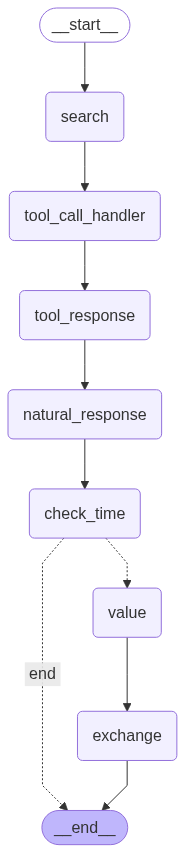

In [265]:
from langgraph.prebuilt import ToolNode
from langgraph.graph.message import add_messages


workflow = StateGraph(AgentState)

tool_node = ToolNode(tools=tools)

# Dodajemy węzły
workflow.add_node("search", search_node) 
workflow.add_node("tool_call_handler", ToolNode(tools))  
workflow.add_node("tool_response", tool_response_node)
workflow.add_node("natural_response", natural_response_node)
workflow.add_node("check_time", check_time_node)
workflow.add_node("value", value_node)
workflow.add_node("exchange", exchange_node)


workflow.set_entry_point("search")
workflow.add_edge("search", "tool_call_handler")
workflow.add_edge("tool_call_handler", "tool_response")
workflow.add_edge("tool_response", "natural_response")
workflow.add_edge("natural_response", "check_time")

workflow.add_conditional_edges(
    "check_time",
    lambda state: state["next_path"],  
    {
        "value": "value",
        "end": END
    }
)

workflow.add_edge("value", "exchange")

workflow.add_edge("exchange", END)
#workflow.add_edge("check_time", END)


graph = workflow.compile()

from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod

display(Image(graph.get_graph().draw_mermaid_png(draw_method=MermaidDrawMethod.API)))

### Running and testing the implementation

In [271]:
from langchain_core.messages import HumanMessage

question = "Ile czasu zajęło wykonanie akcji ( action) ze statusem close 16.05.2025 dla uzytkownika o mac adress 1e:ea:73:e5:55:b0?"

input_data = {
    "messages": [HumanMessage(content=question)],
    "no_of_iterations": 0
}

print("\n[START] Testowanie LangGraph:\n")

for step, event in enumerate(graph.stream(input_data, stream_mode="values"), 1):
    print(f"\n--- [KROK {step}] ---")
    event["messages"][-1].pretty_print()



[START] Testowanie LangGraph:


--- [KROK 1] ---
================================ Human Message =================================

Ile czasu zajęło wykonanie akcji ( action) ze statusem close 16.05.2025 dla uzytkownika o mac adress 1e:ea:73:e5:55:b0?
[DEBUG] Running agent: Search Agent
[DEBUG] Input messages: ['Ile czasu zajęło wykonanie akcji ( action) ze statusem close 16.05.2025 dla uzytkownika o mac adress 1e:ea:73:e5:55:b0?']
[DEBUG] Output from Search Agent: SQLQuery: ```sql
SELECT SUM(Duration) AS TotalTime
FROM actions
WHERE action = 'close' 
  AND status = 'close' 
  AND user_mac_address = '1e:ea:73:e5:55:b0' 
  AND action_date = '2025-05-16';
```

--- [KROK 2] ---
================================== Ai Message ==================================

SQLQuery: ```sql
SELECT SUM(Duration) AS TotalTime
FROM actions
WHERE action = 'close' 
  AND status = 'close' 
  AND user_mac_address = '1e:ea:73:e5:55:b0' 
  AND action_date = '2025-05-16';
```

--- [KROK 3] ---
====================